# Estimation of Autocorrelation Function (tensor contraction)

## (2d Ising model on Square Lattice with J > 0)

In [1]:
import numpy as np
import numba as nb

In [2]:
import csv
import pickle
import time
from tqdm.auto import trange

In [3]:
import matplotlib.pyplot as plt

In [4]:
types_corr_k_steps_est = nb.types.Tuple((nb.float64, nb.float64, nb.float64[:]))(nb.float64[:], nb.int64)
@nb.cfunc(types_corr_k_steps_est, parallel=True)
def corr_k_step_est_float(sample_array, k_steps_max):
    """
    Args:
        mc_list: (np.array)
        k_steps: (int)
    Return:
        corr_coef: (float)
    """
    sample_len = len(sample_array)
    num_i_steps = sample_len - k_steps_max
    q_mean = np.mean(sample_array[:num_i_steps])
    q_square_mean = np.mean(np.square(sample_array[:num_i_steps]))
    qqk_sum = np.zeros(k_steps_max)
    for i in range(num_i_steps):
        samples_k_sub = sample_array[i:i+k_steps_max+1]
        for j in range(1, k_steps_max+1):
            qqk_sum[j-1] += (samples_k_sub[0] * samples_k_sub[j])
    qqk_array = qqk_sum / num_i_steps
    return (q_mean, q_square_mean, qqk_array)

In [5]:
types_corr_k_steps_est = nb.types.Tuple((nb.float64, nb.float64, nb.float64[:]))(nb.int32[:], nb.int64)
@nb.cfunc(types_corr_k_steps_est, parallel=True)
def corr_k_step_est_int(sample_array, k_steps_max):
    """
    Args:
        mc_list: (np.array)
        k_steps: (int)
    Return:
        corr_coef: (float)
    """
    sample_len = len(sample_array)
    num_i_steps = sample_len - k_steps_max
    q_mean = np.mean(sample_array[:num_i_steps])
    q_square_mean = np.mean(np.square(sample_array[:num_i_steps]))
    qqk_sum = np.zeros(k_steps_max)
    for i in range(num_i_steps):
        samples_k_sub = sample_array[i:i+k_steps_max+1]
        for j in range(1, k_steps_max+1):
            qqk_sum[j-1] += (samples_k_sub[0] * samples_k_sub[j])
    qqk_array = qqk_sum / num_i_steps
    return (q_mean, q_square_mean, qqk_array)

In [6]:
@nb.njit(parallel=True)
def autocorr_mc_mean_est(mc_array, k_steps_max):
    m_times = mc_array.shape[0]
    qqk_mean_mc, qqk_mean_std_mc = np.zeros(k_steps_max), np.zeros(k_steps_max)
    q_mean_array, q_square_mean_array, qqk_double_array = np.zeros(m_times), np.zeros(m_times), np.zeros((m_times, k_steps_max))
    for i in range(m_times):
        q_mean, q_square_mean, qqk_array = corr_k_step_est_float(mc_array[i], k_steps_max)
        q_mean_array[i] = q_mean
        q_square_mean_array[i] = q_square_mean
        qqk_double_array[i] = qqk_array
    for i in range(k_steps_max):
        qqk_mean_mc_i = np.mean(qqk_double_array[:, i])
        qqk_mean_std_mc_i = np.std(qqk_double_array[:, i])
        qqk_mean_mc[i] = qqk_mean_mc_i
        qqk_mean_std_mc[i] = qqk_mean_std_mc_i / np.sqrt(m_times)
    ####################################################
    q_mean_mc = np.mean(q_mean_array)
    q_mean_std_mc = np.std(q_mean_array) / np.sqrt(m_times)
    q_square_mean_mc = np.mean(q_square_mean_array)
    q_square_mean_std_mc = np.std(q_square_mean_array) / np.sqrt(m_times)
    ####################################################
    q_mean = (q_mean_mc, q_mean_std_mc)
    q_square_mean = (q_square_mean_mc, q_square_mean_std_mc)
    qqk_mean = (qqk_mean_mc, qqk_mean_std_mc)
    ####################################################
    autocorr_mc = (qqk_mean_mc - q_mean_mc ** 2) / (q_square_mean_mc - q_mean_mc ** 2) 
    return autocorr_mc, q_mean, q_square_mean, qqk_mean

In [7]:
@nb.njit(parallel=True)
def autocorr_mc_std_est(mc_array, k_steps_max):
    m_times = mc_array.shape[0]
    qqk_mean_mc, qqk_mean_std_mc = np.zeros(k_steps_max), np.zeros(k_steps_max)
    q_mean_array, q_square_mean_array, qqk_double_array = np.zeros((m_times, 1)), np.zeros((m_times, 1)), np.zeros((m_times, k_steps_max))
    autocorr_mc_mean, autocorr_mc_std = np.zeros(k_steps_max), np.zeros(k_steps_max)
    for i in range(m_times):
        q_mean, q_square_mean, qqk_array = corr_k_step_est_float(mc_array[i], k_steps_max)
        q_mean_array[i] = q_mean
        q_square_mean_array[i] = q_square_mean
        qqk_double_array[i] = qqk_array        
    ####################################################
    autocorr_mc_array = (qqk_double_array - q_mean_array ** 2) / (q_square_mean_array - q_mean_array ** 2)
    q_mean_mc = np.mean(q_mean_array)
    q_square_mean_mc = np.mean(q_square_mean_array)
    qqk_mc = np.mean(qqk_double_array)
    for j in range(k_steps_max):
        autocorr_mc_mean[j] = np.mean(autocorr_mc_array[:, j])
        autocorr_mc_std[j] = np.std(autocorr_mc_array[:, j]) / np.sqrt(m_times)
    return autocorr_mc_mean, autocorr_mc_std

-----------
### 4 x 4 Square 2D Ising Model

In [8]:
with open('../data_2d_ising/ising2d_size_4_beta_0.441_tensor_1E7_m.pkl', 'rb') as file:
    m_2dising_4_j_pos = pickle.load(file)

In [9]:
m_abs_2dising_4_j_pos = np.abs(m_2dising_4_j_pos)

In [10]:
m_abs_2dising_4_j_pos = m_abs_2dising_4_j_pos.reshape((10000, 1000))

In [11]:
time_start = time.time()
autocorr_m_abs_2dising_4_j_pos_mean, _, _, _ = autocorr_mc_mean_est(m_abs_2dising_4_j_pos, 100)
_, autocorr_m_abs_2dising_4_j_pos_std = autocorr_mc_std_est(m_abs_2dising_4_j_pos, 100)
time_end = time.time()
print(time_end-time_start)

120.7599265575409


In [12]:
autocorr_m_abs_2dising_4_j_pos_mean = np.insert(autocorr_m_abs_2dising_4_j_pos_mean, 0, 1)

In [13]:
autocorr_m_abs_2dising_4_j_pos_std = np.insert(autocorr_m_abs_2dising_4_j_pos_std, 0, 0)

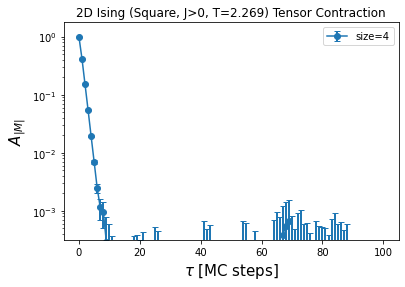

In [14]:
plt.errorbar(x=range(101), y=autocorr_m_abs_2dising_4_j_pos_mean, yerr=autocorr_m_abs_2dising_4_j_pos_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=4')
plt.yscale("log")
plt.ylim(10**-3.5)
plt.xlabel(r'$\tau$ [MC steps]', fontsize=15)
plt.ylabel(r'$A_{|M|}$', fontsize=15)
plt.title("2D Ising (Square, J>0, T=2.269) Tensor Contraction")
plt.legend()

In [15]:
m_abs_2dising_4_j_pos_mean = np.mean(m_abs_2dising_4_j_pos)

In [16]:
print(f"|m| of size 4 is: {m_abs_2dising_4_j_pos_mean:.3f}.")

|m| of size 4 is: 0.844.


In [17]:
autocorr_time_size_4 = np.sum(autocorr_m_abs_2dising_4_j_pos_mean[:20]) - 1/2

In [18]:
print(f"autocorr time of size 4 is: {autocorr_time_size_4:.3f}.")

autocorr time of size 4 is: 1.151.


----
### Size = 8

In [19]:
with open('../data_2d_ising/ising2d_size_8_beta_0.441_tensor_1E7_m.pkl', 'rb') as file:
    m_2dising_8_j_pos = pickle.load(file)

In [20]:
m_abs_2dising_8_j_pos = np.abs(m_2dising_8_j_pos)

In [21]:
m_abs_2dising_8_j_pos_mean = np.mean(m_abs_2dising_8_j_pos)

In [22]:
print(f"|m| of size 8 is: {m_abs_2dising_8_j_pos_mean:.3f}.")

|m| of size 8 is: 0.777.


In [23]:
m_abs_2dising_8_j_pos = m_abs_2dising_8_j_pos.reshape((10000, 1000))

In [24]:
time_start = time.time()
autocorr_m_abs_2dising_8_j_pos_mean, _, _, _ = autocorr_mc_mean_est(m_abs_2dising_8_j_pos, 100)
_, autocorr_m_abs_2dising_8_j_pos_std = autocorr_mc_std_est(m_abs_2dising_8_j_pos, 100)
time_end = time.time()
print(time_end-time_start)

113.21969556808472


In [25]:
autocorr_m_abs_2dising_8_j_pos_mean = np.insert(autocorr_m_abs_2dising_8_j_pos_mean, 0, 1)

In [26]:
autocorr_m_abs_2dising_8_j_pos_std = np.insert(autocorr_m_abs_2dising_8_j_pos_std, 0, 0)

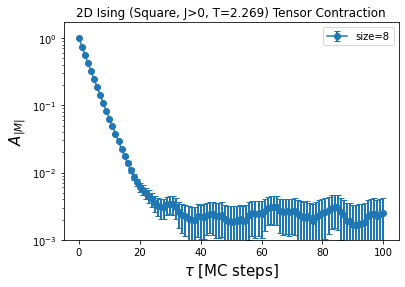

In [27]:
plt.errorbar(x=range(101), y=autocorr_m_abs_2dising_8_j_pos_mean, yerr=autocorr_m_abs_2dising_8_j_pos_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=8')
plt.yscale("log")
plt.ylim(10**-3)
plt.xlabel(r'$\tau$ [MC steps]', fontsize=15)
plt.ylabel(r'$A_{|M|}$', fontsize=15)
plt.title("2D Ising (Square, J>0, T=2.269) Tensor Contraction")
plt.legend()

In [28]:
autocorr_time_size_8 = np.sum(autocorr_m_abs_2dising_8_j_pos_mean[:70]) - 1/2

In [29]:
print(f"autocorr time of size 8 is: {autocorr_time_size_8:.3f}.")

autocorr time of size 8 is: 3.704.


-----------
### Size = 16

In [30]:
with open('../data_2d_ising/ising2d_size_16_beta_0.441_tensor_1E7_m.pkl', 'rb') as file:
    m_2dising_16_j_pos = pickle.load(file)

In [31]:
m_abs_2dising_16_j_pos = np.abs(m_2dising_16_j_pos)

In [32]:
m_abs_2dising_16_j_pos_mean = np.mean(m_abs_2dising_16_j_pos)

In [33]:
print(f"|m| of size 16 is: {m_abs_2dising_16_j_pos_mean:.3f}.")

|m| of size 16 is: 0.714.


In [34]:
m_abs_2dising_16_j_pos = m_abs_2dising_16_j_pos.reshape((10000, 1000))

In [35]:
time_start = time.time()
autocorr_m_abs_2dising_16_j_pos_mean, _, _, _ = autocorr_mc_mean_est(m_abs_2dising_16_j_pos, 100)
_, autocorr_m_abs_2dising_16_j_pos_std = autocorr_mc_std_est(m_abs_2dising_16_j_pos, 100)
time_end = time.time()
print(time_end-time_start)

109.87446999549866


In [36]:
autocorr_m_abs_2dising_16_j_pos_mean = np.insert(autocorr_m_abs_2dising_16_j_pos_mean, 0, 1)

In [37]:
autocorr_m_abs_2dising_16_j_pos_std = np.insert(autocorr_m_abs_2dising_16_j_pos_std, 0, 0)

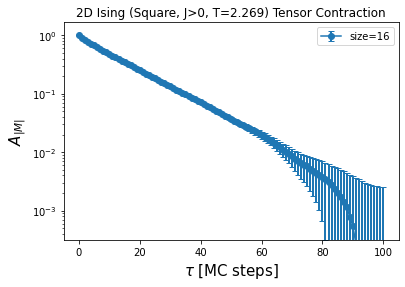

In [38]:
plt.errorbar(x=range(101), y=autocorr_m_abs_2dising_16_j_pos_mean, yerr=autocorr_m_abs_2dising_16_j_pos_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=16')
plt.yscale("log")
plt.ylim(10**-3.5)
plt.xlabel(r'$\tau$ [MC steps]', fontsize=15)
plt.ylabel(r'$A_{|M|}$', fontsize=15)
plt.title("2D Ising (Square, J>0, T=2.269) Tensor Contraction")
plt.legend()

In [39]:
autocorr_time_size_16 = np.sum(autocorr_m_abs_2dising_16_j_pos_mean[:80]) - 1/2

In [40]:
print(f"autocorr time of size 16 is: {autocorr_time_size_16:.3f}.")

autocorr time of size 16 is: 14.311.


-----------
### Size = 32

In [21]:
with open('../data_2d_ising/ising2d_size_32_beta_0.441_tensor_1E7_m.pkl', 'rb') as file:
    m_2dising_32_j_pos = pickle.load(file)

In [22]:
m_abs_2dising_32_j_pos = np.abs(m_2dising_32_j_pos)

In [23]:
m_abs_2dising_32_j_pos_mean = np.mean(m_abs_2dising_32_j_pos)

In [ ]:
print(f"|m| of size 32 is: {m_abs_2dising_32_j_pos_mean:.3f}.")

|m| of size 32 is: 0.656.


In [26]:
m_abs_2dising_32_j_pos = m_abs_2dising_32_j_pos.reshape((10000, 1000))

In [27]:
time_start = time.time()
autocorr_m_abs_2dising_32_j_pos_mean, _, _, _ = autocorr_mc_mean_est(m_abs_2dising_32_j_pos, 100)
_, autocorr_m_abs_2dising_32_j_pos_std = autocorr_mc_std_est(m_abs_2dising_32_j_pos, 100)
time_end = time.time()
print(time_end-time_start)

65.39825773239136


In [28]:
autocorr_m_abs_2dising_32_j_pos_mean = np.insert(autocorr_m_abs_2dising_32_j_pos_mean, 0, 1)

In [29]:
autocorr_m_abs_2dising_32_j_pos_std = np.insert(autocorr_m_abs_2dising_32_j_pos_std, 0, 0)

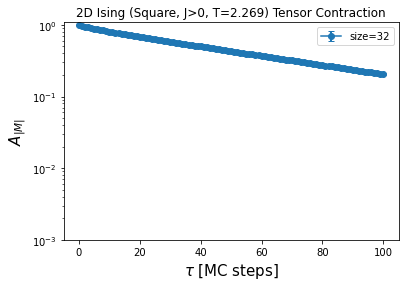

In [30]:
plt.errorbar(x=range(101), y=autocorr_m_abs_2dising_32_j_pos_mean, yerr=autocorr_m_abs_2dising_32_j_pos_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=32')
plt.yscale("log")
plt.ylim(10**-3)
plt.xlabel(r'$\tau$ [MC steps]', fontsize=15)
plt.ylabel(r'$A_{|M|}$', fontsize=15)
plt.title("2D Ising (Square, J>0, T=2.269) Tensor Contraction")
plt.legend()

In [31]:
autocorr_time_size_32 = np.sum(autocorr_m_abs_2dising_32_j_pos_mean) - 1/2

In [32]:
print(f"autocorr time of size 32 is: {autocorr_time_size_32:.3f}.")

autocorr time of size 32 is: 47.910.


--------------
#### Summary

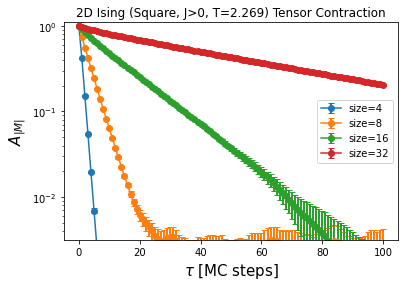

In [56]:
plt.errorbar(x=range(101), y=autocorr_m_abs_2dising_4_j_pos_mean, yerr=autocorr_m_abs_2dising_4_j_pos_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=4')
plt.errorbar(x=range(101), y=autocorr_m_abs_2dising_8_j_pos_mean, yerr=autocorr_m_abs_2dising_8_j_pos_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=8')
plt.errorbar(x=range(101), y=autocorr_m_abs_2dising_16_j_pos_mean, yerr=autocorr_m_abs_2dising_16_j_pos_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=16')
plt.errorbar(x=range(101), y=autocorr_m_abs_2dising_32_j_pos_mean, yerr=autocorr_m_abs_2dising_32_j_pos_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=32')
plt.yscale("log")
plt.ylim(10**-2.5, 1.1)
plt.xlabel(r'$\tau$ [MC steps]', fontsize=15)
plt.ylabel(r'$A_{|M|}$', fontsize=15)
plt.title("2D Ising (Square, J>0, T=2.269) Tensor Contraction")
plt.legend()

### Size effect and Dynamical Exponent

In [63]:
size_array = np.array([4, 8, 16, 32])

In [64]:
autocorr_fun_array = np.array([m_abs_2dising_4_j_pos_mean, 
                               m_abs_2dising_8_j_pos_mean,
                               m_abs_2dising_16_j_pos_mean,
                               m_abs_2dising_32_j_pos_mean])

Text(0.5, 1.0, 'Size Effect on Square 2D Ising (J > 0) Metropolis')

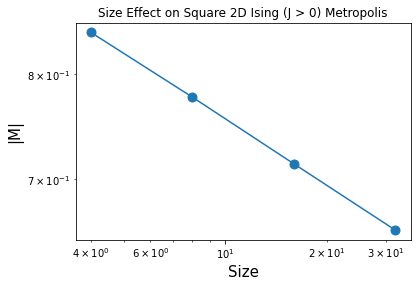

In [65]:
plt.plot(size_array, autocorr_fun_array, '-o', markersize=9)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Size", fontsize=15)
plt.ylabel("|M|", fontsize=15)
plt.title("Size Effect on Square 2D Ising (J > 0) Metropolis")

In [72]:
autocorr_time_array = np.array([autocorr_time_size_4, autocorr_time_size_8, 
                                autocorr_time_size_16, autocorr_time_size_32])
size_array = np.array([4, 8, 16, 32])

In [76]:
autocorr_time_size_32

47.91020181081646

In [73]:
index_metropolis, bias = np.polyfit(np.log(size_array), np.log(autocorr_time_array), 1)

In [74]:
print(f"index of metropolis is about: {index_metropolis:.3f}.")

index of metropolis is about: 1.809.


Text(0.5, 1.0, 'Metropolis on Ising 2D Square Lattice (J > 0), Z=1.809')

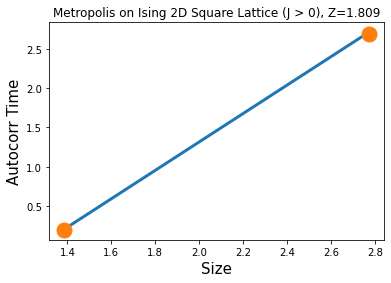

In [155]:
plt.plot(np.log(size_array), index_metropolis*np.log(size_array) + bias, linewidth=3)
plt.plot(np.log(size_array), np.log(autocorr_time_array), 'o', markersize=15)
plt.xlabel("Size", fontsize=15)
plt.ylabel("Autocorr Time", fontsize=15)
plt.title("Metropolis on Ising 2D Square Lattice (J > 0), Z=1.809")

--------------------
## Chain Evolution on Square Lattice (tensor contraction with transpose)

### Size = 4

In [8]:
with open('../data_2d_ising/ising2d_size_4_beta_0.441_tensor_transpose_1E7_m.pkl', 'rb') as file:
    m_2dising_4_j_pos = pickle.load(file)

In [9]:
m_abs_2dising_4_j_pos = np.abs(m_2dising_4_j_pos)

In [87]:
m_abs_2dising_4_j_pos_mean = np.mean(m_abs_2dising_4_j_pos)

In [89]:
print(f"|m| of size 4 is: {m_abs_2dising_4_j_pos_mean}.")

|m| of size 4 is: 0.843891625.


In [10]:
m_abs_2dising_4_j_pos = m_abs_2dising_4_j_pos.reshape((10000, 1000))

In [11]:
time_start = time.time()
autocorr_m_abs_2dising_4_j_pos_mean, _, _, _ = autocorr_mc_mean_est(m_abs_2dising_4_j_pos, 100)
_, autocorr_m_abs_2dising_4_j_pos_std = autocorr_mc_std_est(m_abs_2dising_4_j_pos, 100)
time_end = time.time()
print(time_end-time_start)

135.60443568229675


In [12]:
autocorr_m_abs_2dising_4_j_pos_mean = np.insert(autocorr_m_abs_2dising_4_j_pos_mean, 0, 1)

In [13]:
autocorr_m_abs_2dising_4_j_pos_std = np.insert(autocorr_m_abs_2dising_4_j_pos_std, 0, 0)

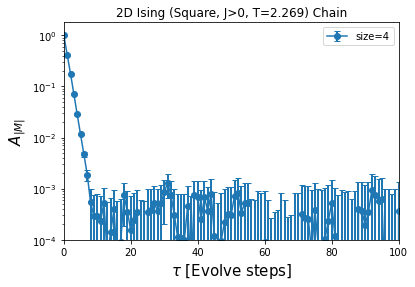

In [14]:
plt.errorbar(x=range(101), y=autocorr_m_abs_2dising_4_j_pos_mean, yerr=autocorr_m_abs_2dising_4_j_pos_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=4')
plt.yscale("log")
plt.ylim(10**-4)
plt.xlim(0, 100)
plt.xlabel(r'$\tau$ [Evolve steps]', fontsize=15)
plt.ylabel(r'$A_{|M|}$', fontsize=15)
plt.title("2D Ising (Square, J>0, T=2.269) Chain")
plt.legend()

In [15]:
autocorr_time_size_4 = np.sum(autocorr_m_abs_2dising_4_j_pos_mean[:10]) - 1/2

In [16]:
print(f"autocorr time of size 4 is: {autocorr_time_size_4:.3f}.")

autocorr time of size 4 is: 1.215.


-----
### Size = 8

In [65]:
with open('../data_2d_ising/ising2d_size_8_beta_0.441_tensor_transpose_1E7_m.pkl', 'rb') as file:
    m_2dising_8_j_pos = pickle.load(file)

In [66]:
m_abs_2dising_8_j_pos = np.abs(m_2dising_8_j_pos)

In [67]:
m_abs_2dising_8_j_pos_mean = np.mean(m_abs_2dising_8_j_pos)

In [68]:
print(f"|m| of size 8 is: {m_abs_2dising_size_8_j_pos_mean}.")

|m| of size 8 is: 0.777229425.


In [69]:
m_abs_2dising_8_j_pos = m_abs_2dising_8_j_pos.reshape((10000, 1000))

In [70]:
time_start = time.time()
autocorr_m_abs_2dising_8_j_pos_mean, _, _, _ = autocorr_mc_mean_est(m_abs_2dising_size_8_j_pos, 100)
_, autocorr_m_abs_2dising_8_j_pos_std = autocorr_mc_std_est(m_abs_2dising_8_j_pos, 100)
time_end = time.time()
print(time_end-time_start)

113.45912003517151


In [71]:
autocorr_m_abs_2dising_8_j_pos_mean = np.insert(autocorr_m_abs_2dising_8_j_pos_mean, 0, 1)

In [72]:
autocorr_m_abs_2dising_8_j_pos_std = np.insert(autocorr_m_abs_2dising_8_j_pos_std, 0, 0)

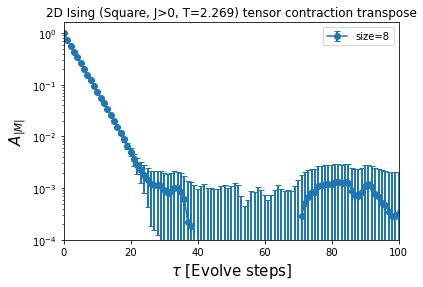

In [73]:
plt.errorbar(x=range(101), y=autocorr_m_abs_2dising_8_j_pos_mean, yerr=autocorr_m_abs_2dising_8_j_pos_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=8')
plt.yscale("log")
plt.ylim(10**-4)
plt.xlim(0, 100)
plt.xlabel(r'$\tau$ [Evolve steps]', fontsize=15)
plt.ylabel(r'$A_{|M|}$', fontsize=15)
plt.title("2D Ising (Square, J>0, T=2.269) tensor contraction transpose")
plt.legend()

In [74]:
autocorr_time_size_8 = np.sum(autocorr_m_abs_2dising_8_j_pos_mean[:25]) - 1/2

In [75]:
print(f"autocorr time of size 8 is: {autocorr_time_size_8:.3f}.")

autocorr time of size 8 is: 3.744.


-------
### Size = 16

In [28]:
with open('../data_2d_ising/ising2d_size_16_beta_0.441_tensor_transpose_1E7_m.pkl', 'rb') as file:
    m_2dising_16_j_pos = pickle.load(file)

In [29]:
m_abs_2dising_16_j_pos = np.abs(m_2dising_16_j_pos)

In [30]:
m_abs_2dising_16_j_pos_mean = np.mean(m_abs_2dising_16_j_pos)

In [31]:
print(f"|m| of size 16 is: {m_abs_2dising_16_j_pos_mean}.")

|m| of size 16 is: 0.71378966328125.


In [32]:
m_abs_2dising_16_j_pos = m_abs_2dising_16_j_pos.reshape((10000, 1000))

In [33]:
time_start = time.time()
autocorr_m_abs_2dising_16_j_pos_mean, _, _, _ = autocorr_mc_mean_est(m_abs_2dising_16_j_pos, 100)
_, autocorr_m_abs_2dising_16_j_pos_std = autocorr_mc_std_est(m_abs_2dising_16_j_pos, 100)
time_end = time.time()
print(time_end-time_start)

114.83318996429443


In [34]:
autocorr_m_abs_2dising_16_j_pos_mean = np.insert(autocorr_m_abs_2dising_16_j_pos_mean, 0, 1)

In [35]:
autocorr_m_abs_2dising_16_j_pos_std = np.insert(autocorr_m_abs_2dising_16_j_pos_std, 0, 0)

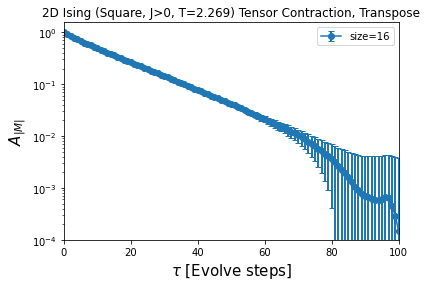

In [36]:
plt.errorbar(x=range(101), y=autocorr_m_abs_2dising_16_j_pos_mean, yerr=autocorr_m_abs_2dising_16_j_pos_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=16')
plt.yscale("log")
plt.ylim(10**-4)
plt.xlim(0, 100)
plt.xlabel(r'$\tau$ [Evolve steps]', fontsize=15)
plt.ylabel(r'$A_{|M|}$', fontsize=15)
plt.title("2D Ising (Square, J>0, T=2.269) Tensor Contraction, Transpose")
plt.legend()

In [37]:
autocorr_time_size_16 = np.sum(autocorr_m_abs_2dising_16_j_pos_mean[:75]) - 1/2

In [38]:
print(f"autocorr time of size 16 is: {autocorr_time_size_16:.3f}.")

autocorr time of size 16 is: 14.762.


-----
### Size = 32

In [39]:
with open('../data_2d_ising/ising2d_size_32_beta_0.441_tensor_transpose_1E7_m.pkl', 'rb') as file:
    m_2dising_32_j_pos = pickle.load(file)

In [41]:
m_abs_2dising_32_j_pos = np.abs(m_2dising_32_j_pos)

In [42]:
m_abs_2dising_32_j_pos_mean = np.mean(m_abs_2dising_32_j_pos)

In [43]:
print(f"|m| of size 32 is: {m_abs_2dising_32_j_pos_mean}.")

|m| of size 32 is: 0.6543241083984375.


In [44]:
m_abs_2dising_32_j_pos = m_abs_2dising_32_j_pos.reshape((10000, 1000))

In [45]:
time_start = time.time()
autocorr_m_abs_2dising_32_j_pos_mean, _, _, _ = autocorr_mc_mean_est(m_abs_2dising_32_j_pos, 100)
_, autocorr_m_abs_2dising_32_j_pos_std = autocorr_mc_std_est(m_abs_2dising_32_j_pos, 100)
time_end = time.time()
print(time_end-time_start)

116.70149183273315


In [46]:
autocorr_m_abs_2dising_32_j_pos_mean= np.insert(autocorr_m_abs_2dising_32_j_pos_mean, 0, 1)

In [47]:
autocorr_m_abs_2dising_32_j_pos_std = np.insert(autocorr_m_abs_2dising_32_j_pos_std, 0, 0)

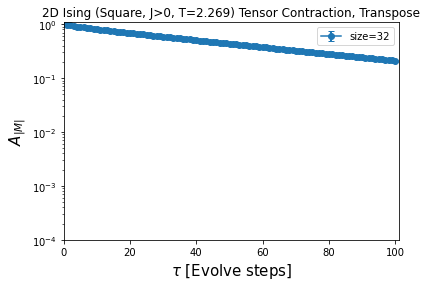

In [48]:
plt.errorbar(x=range(101), y=autocorr_m_abs_2dising_32_j_pos_mean, yerr=autocorr_m_abs_2dising_32_j_pos_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=32')
plt.yscale("log")
plt.ylim(10**-4)
plt.xlim(0, 101)
plt.xlabel(r'$\tau$ [Evolve steps]', fontsize=15)
plt.ylabel(r'$A_{|M|}$', fontsize=15)
plt.title("2D Ising (Square, J>0, T=2.269) Tensor Contraction, Transpose")
plt.legend()

In [50]:
autocorr_time_size_32 = np.sum(autocorr_m_abs_2dising_32_j_pos_mean) - 1/2

In [51]:
print(f"autocorr time of size 32 is: {autocorr_time_size_32:.3f}.")

autocorr time of size 32 is: 48.431.


------
### Summary

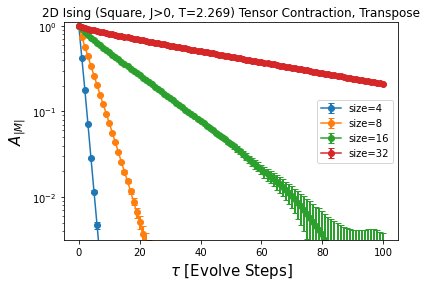

In [76]:
plt.errorbar(x=range(101), y=autocorr_m_abs_2dising_4_j_pos_mean, 
             yerr=autocorr_m_abs_2dising_4_j_pos_std, fmt='-o', capsize=3, 
             elinewidth=2, label='size=4')
plt.errorbar(x=range(101), y=autocorr_m_abs_2dising_8_j_pos_mean, 
             yerr=autocorr_m_abs_2dising_8_j_pos_std, fmt='-o', capsize=3, 
             elinewidth=2, label='size=8')
plt.errorbar(x=range(101), y=autocorr_m_abs_2dising_16_j_pos_mean, 
             yerr=autocorr_m_abs_2dising_16_j_pos_std, fmt='-o', capsize=3, 
             elinewidth=2, label='size=16')
plt.errorbar(x=range(101), y=autocorr_m_abs_2dising_32_j_pos_mean, 
             yerr=autocorr_m_abs_2dising_32_j_pos_std, fmt='-o', capsize=3, 
             elinewidth=2, label='size=32')
plt.yscale("log")
plt.ylim(10**-2.5, 1.1)
plt.xlabel(r'$\tau$ [Evolve Steps]', fontsize=15)
plt.ylabel(r'$A_{|M|}$', fontsize=15)
plt.title("2D Ising (Square, J>0, T=2.269) Tensor Contraction, Transpose")
plt.legend()

-------
### dynamical exponent

In [77]:
autocorr_time_array = np.array([autocorr_time_size_4, 
                                autocorr_time_size_8, 
                                autocorr_time_size_16, 
                                autocorr_time_size_32])
size_array = np.array([4, 8, 16, 32])

In [78]:
index_chain, bias = np.polyfit(np.log(size_array), np.log(autocorr_time_array), 1)

In [79]:
print(f"index of chain evolution is about: {index_chain:.3f}.")

index of chain evolution is about: 1.793.


Text(0.5, 1.0, 'Chain on Ising 2D Square Lattice (J > 0), Z=1.516')

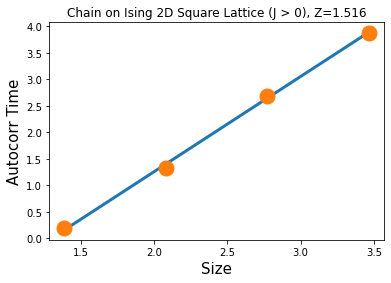

In [80]:
plt.plot(np.log(size_array), index_chain*np.log(size_array) + bias, linewidth=3)
plt.plot(np.log(size_array), np.log(autocorr_time_array), 'o', markersize=15)
plt.xlabel("Size", fontsize=15)
plt.ylabel("Autocorr Time", fontsize=15)
plt.title("Chain on Ising 2D Square Lattice (J > 0), Z=1.516")

-----
### Size effects

In [93]:
autocorr_fun_array = np.array([m_abs_2dising_4_j_pos_mean, 
                               m_abs_2dising_8_j_pos_mean,
                               m_abs_2dising_16_j_pos_mean,
                               m_abs_2dising_32_j_pos_mean])

In [94]:
coef_autocorr, bias = np. polyfit(size_array, autocorr_fun_array, 1)

Text(0.5, 1.0, 'Size effect on 2D Ising Square Lattice (J > 0)')

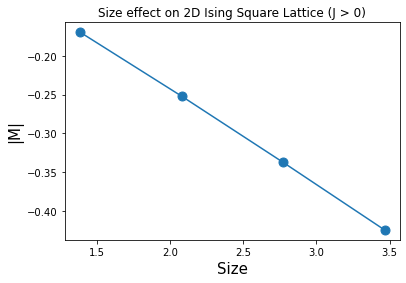

In [96]:
#plt.plot(size_array, coef_autocorr*size_array + bias, linewidth=3)
plt.plot(np.log(size_array), np.log(autocorr_fun_array), '-o', markersize=9)
plt.xlabel("Size", fontsize=15)
plt.ylabel("|M|", fontsize=15)
plt.title("Size effect on 2D Ising Square Lattice (J > 0)")

--------------------
## Chain Evolution on Square Lattice (tensor contraction with transpose, another line)

--------
### Size = 4

In [97]:
with open('../data_2d_ising/ising2d_size_4_beta_0.441_tensor_transpose_another_line_1E7_m.pkl', 'rb') as file:
    m_2dising_4_j_pos = pickle.load(file)

In [98]:
m_abs_2dising_4_j_pos = np.abs(m_2dising_4_j_pos)

In [99]:
m_abs_2dising_4_j_pos_mean = np.mean(m_abs_2dising_4_j_pos)

In [100]:
print(f"|m| of size 4 is: {m_abs_2dising_4_j_pos_mean}.")

|m| of size 4 is: 0.8439523375.


In [101]:
m_abs_2dising_4_j_pos = m_abs_2dising_4_j_pos.reshape((10000, 1000))

In [102]:
time_start = time.time()
autocorr_m_abs_2dising_4_j_pos_mean, _, _, _ = autocorr_mc_mean_est(m_abs_2dising_4_j_pos, 100)
_, autocorr_m_abs_2dising_4_j_pos_std = autocorr_mc_std_est(m_abs_2dising_4_j_pos, 100)
time_end = time.time()
print(time_end-time_start)

97.54481410980225


In [103]:
autocorr_m_abs_2dising_4_j_pos_mean = np.insert(autocorr_m_abs_2dising_4_j_pos_mean, 0, 1)

In [104]:
autocorr_m_abs_2dising_4_j_pos_std = np.insert(autocorr_m_abs_2dising_4_j_pos_std, 0, 0)

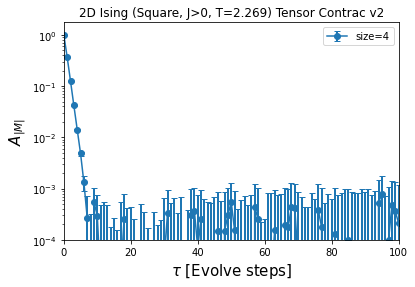

In [106]:
plt.errorbar(x=range(101), y=autocorr_m_abs_2dising_4_j_pos_mean, yerr=autocorr_m_abs_2dising_4_j_pos_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=4')
plt.yscale("log")
plt.ylim(10**-4)
plt.xlim(0, 100)
plt.xlabel(r'$\tau$ [Evolve steps]', fontsize=15)
plt.ylabel(r'$A_{|M|}$', fontsize=15)
plt.title("2D Ising (Square, J>0, T=2.269) Tensor Contrac v2")
plt.legend()

In [112]:
autocorr_time_size_4 = np.sum(autocorr_m_abs_2dising_4_j_pos_mean[:20]) - 1/2

In [113]:
print(f"autocorr time of size 4 is: {autocorr_time_size_4:.3f}.")

autocorr time of size 4 is: 1.057.


------------------------------
### Size = 8

In [114]:
with open('../data_2d_ising/ising2d_size_8_beta_0.441_tensor_transpose_another_line_1E7_m.pkl', 'rb') as file:
    m_2dising_8_j_pos = pickle.load(file)

In [115]:
m_abs_2dising_8_j_pos = np.abs(m_2dising_8_j_pos)

In [116]:
m_abs_2dising_8_j_pos_mean = np.mean(m_abs_2dising_8_j_pos)

In [117]:
print(f"|m| of size 8 is: {m_abs_2dising_8_j_pos_mean}.")

|m| of size 8 is: 0.777243453125.


In [118]:
m_abs_2dising_8_j_pos = m_abs_2dising_8_j_pos.reshape((10000, 1000))

In [119]:
time_start = time.time()
autocorr_m_abs_2dising_8_j_pos_mean, _, _, _ = autocorr_mc_mean_est(m_abs_2dising_8_j_pos, 100)
_, autocorr_m_abs_2dising_8_j_pos_std = autocorr_mc_std_est(m_abs_2dising_8_j_pos, 100)
time_end = time.time()
print(time_end-time_start)

98.13910818099976


In [120]:
autocorr_m_abs_2dising_8_j_pos_mean = np.insert(autocorr_m_abs_2dising_8_j_pos_mean, 0, 1)

In [121]:
autocorr_m_abs_2dising_8_j_pos_std = np.insert(autocorr_m_abs_2dising_8_j_pos_std, 0, 0)

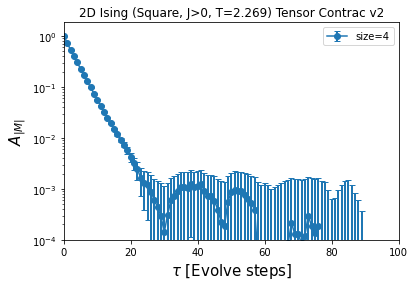

In [122]:
plt.errorbar(x=range(101), y=autocorr_m_abs_2dising_8_j_pos_mean, yerr=autocorr_m_abs_2dising_8_j_pos_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=4')
plt.yscale("log")
plt.ylim(10**-4)
plt.xlim(0, 100)
plt.xlabel(r'$\tau$ [Evolve steps]', fontsize=15)
plt.ylabel(r'$A_{|M|}$', fontsize=15)
plt.title("2D Ising (Square, J>0, T=2.269) Tensor Contrac v2")
plt.legend()

In [124]:
autocorr_time_size_8 = np.sum(autocorr_m_abs_2dising_8_j_pos_mean[:30]) - 1/2

In [125]:
print(f"autocorr time of size 8 is: {autocorr_time_size_8:.3f}.")

autocorr time of size 8 is: 3.432.


-----------------------------
### Size = 16

In [20]:
with open('../data_2d_ising/ising2d_size_16_beta_0.441_tensor_transpose_another_line_1E7_m.pkl', 'rb') as file:
    m_2dising_16_j_pos = pickle.load(file)

In [21]:
m_abs_2dising_16_j_pos = np.abs(m_2dising_16_j_pos)

In [22]:
m_abs_2dising_16_j_pos_mean = np.mean(m_abs_2dising_16_j_pos)

In [23]:
print(f"|m| of size 16 is: {m_abs_2dising_16_j_pos_mean}.")

|m| of size 16 is: 0.7138249796875.


In [24]:
m_abs_2dising_16_j_pos = m_abs_2dising_16_j_pos.reshape((10000, 1000))

In [25]:
time_start = time.time()
autocorr_m_abs_2dising_16_j_pos_mean, _, _, _ = autocorr_mc_mean_est(m_abs_2dising_16_j_pos, 100)
_, autocorr_m_abs_2dising_16_j_pos_std = autocorr_mc_std_est(m_abs_2dising_16_j_pos, 100)
time_end = time.time()
print(time_end-time_start)

120.8750250339508


In [26]:
autocorr_m_abs_2dising_16_j_pos_mean = np.insert(autocorr_m_abs_2dising_16_j_pos_mean, 0, 1)

In [27]:
autocorr_m_abs_2dising_16_j_pos_std = np.insert(autocorr_m_abs_2dising_16_j_pos_std, 0, 0)

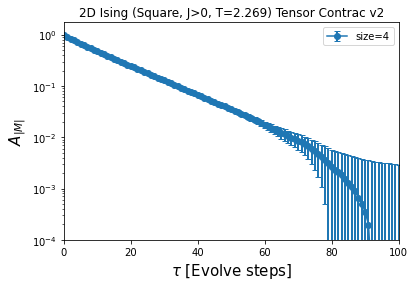

In [28]:
plt.errorbar(x=range(101), y=autocorr_m_abs_2dising_16_j_pos_mean, yerr=autocorr_m_abs_2dising_16_j_pos_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=4')
plt.yscale("log")
plt.ylim(10**-4)
plt.xlim(0, 100)
plt.xlabel(r'$\tau$ [Evolve steps]', fontsize=15)
plt.ylabel(r'$A_{|M|}$', fontsize=15)
plt.title("2D Ising (Square, J>0, T=2.269) Tensor Contrac v2")
plt.legend()

In [31]:
autocorr_time_size_16 = np.sum(autocorr_m_abs_2dising_16_j_pos_mean[:75]) - 1/2

In [32]:
print(f"autocorr time of size 16 is: {autocorr_time_size_16:.3f}.")

autocorr time of size 16 is: 13.991.


-----------
### Size = 32

In [12]:
with open('../data_2d_ising/ising2d_size_32_beta_0.441_tensor_transpose_another_line_1E7_m.pkl', 'rb') as file:
    m_2dising_32_j_pos = pickle.load(file)

In [13]:
m_abs_2dising_32_j_pos = np.abs(m_2dising_32_j_pos)

In [14]:
m_abs_2dising_32_j_pos_mean = np.mean(m_abs_2dising_32_j_pos)

In [15]:
print(f"|m| of size 32 is: {m_abs_2dising_32_j_pos_mean}.")

|m| of size 32 is: 0.704030771875.


In [ ]:
m_abs_2dising_32_j_pos = m_abs_2dising_32_j_pos.reshape((10000, 1000))

In [ ]:
time_start = time.time()
autocorr_m_abs_2dising_32_j_pos_mean, _, _, _ = autocorr_mc_mean_est(m_abs_2dising_32_j_pos, 100)
_, autocorr_m_abs_2dising_32_j_pos_std = autocorr_mc_std_est(m_abs_2dising_32_j_pos, 100)
time_end = time.time()
print(time_end-time_start)

In [ ]:
autocorr_m_abs_2dising_32_j_pos_mean = np.insert(autocorr_m_abs_2dising_32_j_pos_mean, 0, 1)

In [ ]:
autocorr_m_abs_2dising_32_j_pos_std = np.insert(autocorr_m_abs_2dising_32_j_pos_std, 0, 0)

In [ ]:
plt.errorbar(x=range(101), y=autocorr_m_abs_2dising_32_j_pos_mean, yerr=autocorr_m_abs_2dising_32_j_pos_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=4')
plt.yscale("log")
plt.ylim(10**-4)
plt.xlim(0, 100)
plt.xlabel(r'$\tau$ [Evolve steps]', fontsize=15)
plt.ylabel(r'$A_{|M|}$', fontsize=15)
plt.title("2D Ising (Square, J>0, T=2.269) Tensor Contrac v2")
plt.legend()

In [ ]:
autocorr_time_size_32 = np.sum(autocorr_m_abs_2dising_32_j_pos_mean) - 1/2

In [ ]:
print(f"autocorr time of size 32 is: {autocorr_time_size_32:.3f}.")

----------------------
### Summary

In [43]:
autocorr_time_array = np.array([autocorr_time_size_4, 
                                autocorr_time_size_8, 
                                autocorr_time_size_16,])
#                                autocorr_time_size_32])
size_array = np.array([4, 8, 16])

In [44]:
index_chain, bias = np.polyfit(np.log(size_array), np.log(autocorr_time_array), 1)

In [45]:
print(f"index of chain evolution is about: {index_chain:.3f}.")

index of chain evolution is about: 1.818.


In [46]:
autocorr_fun_array = np.array([m_abs_2dising_4_j_pos_mean, 
                               m_abs_2dising_8_j_pos_mean,
                               m_abs_2dising_16_j_pos_mean,])
#                               m_abs_2dising_32_j_pos_mean])

In [47]:
coef_autocorr, bias = np. polyfit(size_array, autocorr_fun_array, 1)

Text(0.5, 1.0, 'Size effect on 2D Ising Square Lattice (J > 0)')

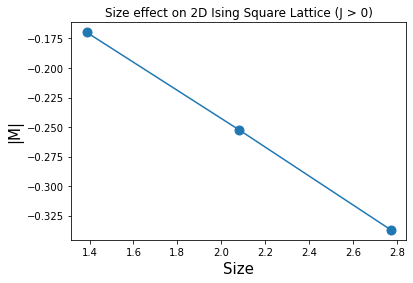

In [48]:
#plt.plot(size_array, coef_autocorr*size_array + bias, linewidth=3)
plt.plot(np.log(size_array), np.log(autocorr_fun_array), '-o', markersize=9)
plt.xlabel("Size", fontsize=15)
plt.ylabel("|M|", fontsize=15)
plt.title("Size effect on 2D Ising Square Lattice (J > 0)")